# Presentation

In [1]:
using SARProcessing, Images, Statistics, SciPy, Plots, Dates

#### Define helper
First we create helper functions we will need for various things:

In [2]:
## small cheat function to easy load the test data 
const folder = "../test/testData/largeFiles/EO_workshop_full/"

const orbit_path = [
    "S1A_OPER_AUX_POEORB_OPOD_20210330T183728_V20190621T225942_20190623T005942.EOF",
    "S1B_OPER_AUX_POEORB_OPOD_20210330T202915_V20190627T225942_20190629T005942.EOF",
    "S1A_OPER_AUX_POEORB_OPOD_20210330T223401_V20190703T225942_20190705T005942.EOF",
    "S1B_OPER_AUX_POEORB_OPOD_20210331T002809_V20190709T225942_20190711T005942.EOF"
    ]


const image_list = [
    "S1A_IW_SLC__1SDV_20190622T015048_20190622T015115_027786_0322F1_7A8E.SAFE",
    "S1B_IW_SLC__1SDV_20190628T014958_20190628T015025_016890_01FC87_FC0D.SAFE",
    "S1A_IW_SLC__1SDV_20190704T015049_20190704T015116_027961_03283A_191E.SAFE",
    "S1B_IW_SLC__1SDV_20190710T014959_20190710T015026_017065_0201B8_069B.SAFE"
    ]

#= # Load workshop related data (very hardcoded)
function load_test_slc_image(folder, image_number)
    tiffs = ["S1A_IW_SLC__1SDV_20190622T015048.tiff","S1B_IW_SLC__1SDV_20190628T014958.tiff",
     "S1A_IW_SLC__1SDV_20190704T015049.tiff", "S1B_IW_SLC__1SDV_20190710T014959.tiff" ]
    annotation_files = ["s1a-iw2-slc-vv-20190622t015048-20190622t015113-027786-0322f1-005.xml",
    "s1b-iw2-slc-vv-20190628t014958-20190628t015023-016890-01fc87-005.xml",
     "s1a-iw2-slc-vv-20190704t015049-20190704t015114-027961-03283a-005.xml",
     "s1b-iw2-slc-vv-20190710t014959-20190710t015024-017065-0201b8-005.xml"]

    tiff_file = tiffs[image_number]
    is_S1A = split(tiff_file,"_")[1] == "S1A"

    window = is_S1A ? [[100 , 1500],[7600 , 20000]] : [[3*1506 , 3*1506+1600],[7500 , 20100]]

    metadata = SARProcessing.Sentinel1MetaData(joinpath(folder, annotation_files[image_number]))
    index_start = (window[1][1],window[2][1])
    data = SARProcessing.load_tiff(joinpath(folder, tiff_file))

    return SARProcessing.Sentinel1SLC(metadata,index_start,data,false)
end =#

# Additinal plotting function, not yet implemented in the SARProcessing.jl package
function plot_multiple_sar(rgb_data; p_quantile = 0.85)
    scaled_data = [ abs2.(data) for data in rgb_data]
    min_value = minimum(reshape(scaled_data[1],:))
    factor = quantile(reshape(scaled_data[1],:),p_quantile) - min_value

    scaled_data = [ (data .- min_value) ./ factor for data in scaled_data]

    img =[Images.Colors.RGB(scaled_data[1][i,j],scaled_data[2][i,j],scaled_data[3][i,j]) 
        for i=1:size(scaled_data[1])[1], j=1:size(scaled_data[1])[2]]
    return img
end

# Additinal plotting function, not yet implemented in the SARProcessing.jl package
function plot_phase(img)
    phase = (angle.(img) .+pi)./(2*pi)

    return Images.Colors.RGB{Float32}.(1 .-phase.^2,4 .*(phase .-  phase.^2),phase.^2)
end

# Additinal coherence estimation function, not yet implemented in the SARProcessing.jl package
function complex_coherence(master, slave, flat, kernel)
    # Define relevant image signals
    signal_1 = master .* conj.(slave) .* flat
    signal_2 = abs2.(master)
    signal_3 = abs2.(slave)
    kernel_1 = convert.(eltype(signal_1),kernel)
    kernel_2 = convert.(eltype(signal_2),kernel)
    kernel_3 = convert.(eltype(signal_3),kernel)

    # Compute real and imaginary parts seperately
    interferogram =  SARProcessing.fastconv(signal_1, kernel_1)
    master_intensity = SARProcessing.fastconv(signal_2, kernel_2)
    slave_intensity = SARProcessing.fastconv(signal_3, kernel_3)

    # Compute the complex coherence
    complex_coherence = interferogram ./ (sqrt.(master_intensity .* slave_intensity));

    return complex_coherence
end;



### Load and visualize a SAR image

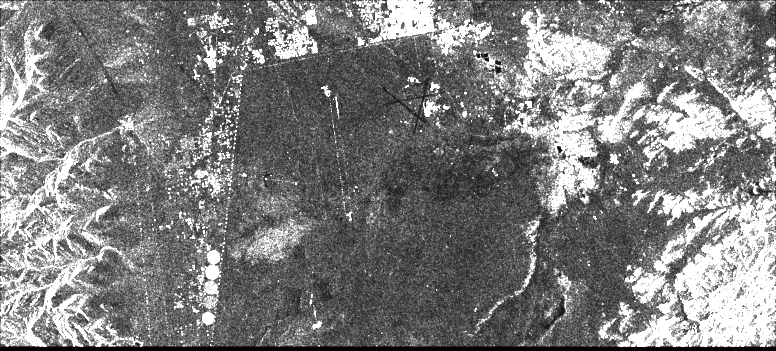

In [3]:
swath = 2 
polarisation = SARProcessing.VV
file_path = joinpath(folder,image_list[1])
sar_image = SARProcessing.load_sentinel1_slc(file_path,polarisation,swath,[[100 , 1500],[7600 , 20000]])
sar_image2 = SARProcessing.load_sentinel1_slc(file_path,polarisation,swath,[[100 , 1500],[7600 , 20000]])
SARProcessing.sar2gray(sar_image.data[:,1:4:end])

In [4]:
orbit_sate_file_path = joinpath(folder, orbit_path[1]);
orbit_states =  SARProcessing.load_precise_orbit_sentinel1(orbit_sate_file_path);
orbit_interpolator1 = SARProcessing.orbit_state_interpolator(orbit_states,sar_image.metadata);

In [5]:

function disturb_orbit(orbit_states, delta_position,delta_t)
    return [SARProcessing.OrbitState(state.time, state.position, state.velocity) for state in orbit_states]
end


disturb_orbit (generic function with 1 method)

In [6]:

orbit_states2 = disturb_orbit(orbit_states, [0,0,0] ,0);
orbit_interpolator2 = SARProcessing.orbit_state_interpolator(orbit_states2,sar_image.metadata);

### Use a digital elevation model to get the heights for the pixel in the SAR image
Instead of guessing the height a much more qualified model is to use a digital elevation model. The model is given in (lat, lon) coordinates, so the first step we need to consider is to convert the height coordinates into SAR indeces. Hereafter we can interpolate the heights to the desired locations in SAR geometry.

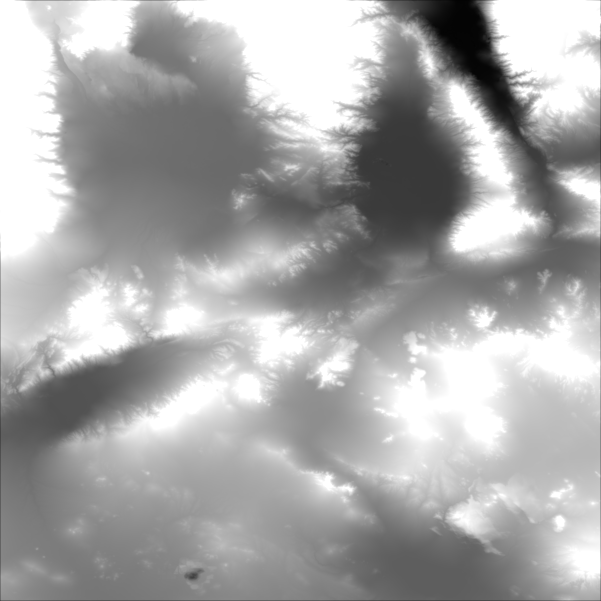

In [7]:
#dem = SARProcessing.load_tandemx_dem(folder*"dem_re2.tif");
dem = SARProcessing.load_tandemx_dem(folder*"TDM1_DEM__30_N35W118_V01_C/DEM/TDM1_DEM__30_N35W118_DEM.tif");

#gdalwarp -s_srs "+proj=longlat +datum=WGS84 +no_defs +geoidgrids=egm96_15.gtx" -t_srs "+proj=longlat +datum=WGS84 +no_def" TDM1_DEM__30_N35W118_DEM.tif dem_re2.tif
SARProcessing.sar2gray(dem.heights)

Now we will just preprocess the DEM data a little:

In [8]:
# helper function to convert latitude and longitude to radians for the DEM heights
dem_geodetic_coordinates = 
[  [ (SARProcessing.get_coordinate(dem,(i,j)) .* (pi/180))...,dem.heights[i,j]] for i=1:size(dem.heights)[1], j=1:size(dem.heights)[2]];


In [9]:
# filter the dem to only the heights in the image
dem_geodetic_coordinates = reshape(dem_geodetic_coordinates,:);

# find the part of the DEM which overlaps with the satellite acquisition
dem_in_image = [ 
    SARProcessing.is_coordinate_in_time_range(SARProcessing.geodetic2ecef(coord)
    ,SARProcessing.get_time_range(sar_image.metadata),orbit_interpolator1) 
    for coord in dem_geodetic_coordinates] 

# crop the DEM, so we only get the area of interest
dem_geodetic_coordinates = dem_geodetic_coordinates[dem_in_image];

## Get the location of the heights in the SAR image 
dem_sar_index = 
[ [SARProcessing.geodetic2SAR_index(coords, orbit_interpolator1, sar_image.metadata,1)...] 
    for coords in dem_geodetic_coordinates];

# unpack the heights that match
heights = [coords[3] for coords in dem_geodetic_coordinates]

## clean up variables
dem_geodetic_coordinates =nothing
dem_in_image = nothing
dem = nothing

Now we transform the the coordinates of the DEM to SAR indeces.

We do not need to compute the height for every single pixel, we can get away with subsampling. So instead we create a grid in the SAR geometry, which is only sampling every 10th row and every 40th column (you can try to vary this if you want)

In [10]:
## Create a grid in the SAR image.
# It is not necessary to interpolate the heights for every pixel, just a grid

rows_range = sar_image.index_start[1] : (sar_image.index_start[1] + size(sar_image.data)[1]-1)
columns_range = sar_image.index_start[2]  : (sar_image.index_start[2] + size(sar_image.data)[2]-1)

rows = collect( rows_range.start:10:rows_range.stop)
columns =  collect( columns_range.start:40:columns_range.stop)

rows_grid = ones(length(columns))' .* rows
columns_grid = columns' .* ones(length(rows));


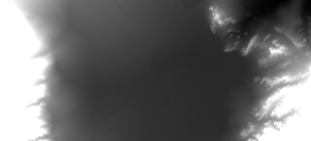

In [11]:
## interpolate the heights to the sar idex grid
interpolated_heights = SciPy.interpolate.griddata(
    hcat(dem_sar_index...)',heights, (reshape(rows_grid,:), reshape(columns_grid,:)) )


interpolated_heights = reshape(interpolated_heights,size(rows_grid))

SARProcessing.sar2gray(interpolated_heights)


How does this look similar to the SAR image in the beginning of the notebook?

### Convert the SAR grid to (lat, lon) - coordinates
Now we can convert the SAR index grid that we defined to (lat, lon) coordinates using the interpolated heights, such that we are able to know where this grid is with respect to another SAR image. This can also be used to resample the SAR image data itself to a regular coordinate grid (this is not recommended for a InSAR processing chain, because it introduces an additional error term).

In [12]:
sar_grid_coordinate = [SARProcessing.sar_index2geodetic(rows[i], columns[j] ,interpolated_heights[i,j],
                orbit_interpolator1,
                sar_image.metadata,1) for i=1:length(rows), j=1:length(columns) ];

## print some coordinate to show
[[sar_grid_coordinate[i,j][1:2] .*180 ./pi,sar_grid_coordinate[i,j][3]] for i = 10:13, j=10:11 ]

4×2 Matrix{Vector{Any}}:
 [[35.6102, -117.928], 1070.33]  [[35.6105, -117.926], 1067.96]
 [[35.6115, -117.928], 1081.15]  [[35.6117, -117.926], 1075.83]
 [[35.6128, -117.928], 1090.05]  [[35.613, -117.927], 1079.19]
 [[35.614, -117.928], 1096.17]   [[35.6142, -117.927], 1080.52]

Every element above is ordered lik [lat, lon, height], and it is clear the a height of 10 meters was a pretty bad guess.

Now we compute the positions in the secondary image corresponding to the grid we defined in the primary image 

In [15]:
# get the grid in image two indecies
grid_image2 =
    [ [SARProcessing.geodetic2SAR_index(coords, orbit_interpolator2, sar_image2.metadata,1)...] 
        for coords in sar_grid_coordinate];
    
    
grid_image2[10:13,10:13]

4×4 Matrix{Vector{Float64}}:
 [190.0, 7960.0]  [190.0, 8000.0]  [190.0, 8040.0]  [190.0, 8080.0]
 [200.0, 7960.0]  [200.0, 8000.0]  [200.0, 8040.0]  [200.0, 8080.0]
 [210.0, 7960.0]  [210.0, 8000.0]  [210.0, 8040.0]  [210.0, 8080.0]
 [220.0, 7960.0]  [220.0, 8000.0]  [220.0, 8040.0]  [220.0, 8080.0]

Here is an example of how a grid point in the primary image is located in the secondary image.

In [45]:
#Fake grid_image2

grid_image2 = [ [rows[i],columns[j]] for i in eachindex(rows), j in eachindex(columns)]

141×311 Matrix{Vector{Int64}}:
 [100, 7600]   [100, 7640]   [100, 7680]   …  [100, 19960]   [100, 20000]
 [110, 7600]   [110, 7640]   [110, 7680]      [110, 19960]   [110, 20000]
 [120, 7600]   [120, 7640]   [120, 7680]      [120, 19960]   [120, 20000]
 [130, 7600]   [130, 7640]   [130, 7680]      [130, 19960]   [130, 20000]
 [140, 7600]   [140, 7640]   [140, 7680]      [140, 19960]   [140, 20000]
 [150, 7600]   [150, 7640]   [150, 7680]   …  [150, 19960]   [150, 20000]
 [160, 7600]   [160, 7640]   [160, 7680]      [160, 19960]   [160, 20000]
 [170, 7600]   [170, 7640]   [170, 7680]      [170, 19960]   [170, 20000]
 [180, 7600]   [180, 7640]   [180, 7680]      [180, 19960]   [180, 20000]
 [190, 7600]   [190, 7640]   [190, 7680]      [190, 19960]   [190, 20000]
 ⋮                                         ⋱                 ⋮
 [1420, 7600]  [1420, 7640]  [1420, 7680]     [1420, 19960]  [1420, 20000]
 [1430, 7600]  [1430, 7640]  [1430, 7680]     [1430, 19960]  [1430, 20000]
 [1440, 7600]  [

In [46]:
(rows[10],columns[13]), grid_image2[10,13]

((190, 8080), [190, 8080])

The image rows are here a bit confusing. The row is counted as the number of unique rows from the first row in the entire Sentinel 1 swath for each image. It is necessary to adjust for the subset index offset and the burst overlap to get the actual row number in the data matrix. We hope to make this more simple in the future by restructuring the data struct and by using the OffsetArrays package. 
We did not do this in the primary image, as we were working with the first burst! But in the secondary image we need to find this offset, and correct correspondingly.

### Deramping
The way that Sentinel-1 steers its' antenna during acquisition gives rise to a phase ramp. We need to correct for the phase ramp before resampling the image, to avoid unwanted spectral artifacts. The details of this process are a bit involved, but we can simply call the `phase_ramp()` function to get the phase ramp, and remove it.

In [47]:
rows_range2 = sar_image2.index_start[1]:(sar_image2.index_start[1] + size(sar_image2.data)[1]-1)
columns_range2 = sar_image2.index_start[2]:(sar_image2.index_start[2] + size(sar_image2.data)[2]-1)

7600:20000

In [48]:
## deramp the data before resampling
if !sar_image2.deramped
    println("Deramping")

    mid_burst_state2 = SARProcessing.get_burst_mid_states(sar_image2, orbit_interpolator2)
    mid_burst_state2 = mid_burst_state2[SARProcessing.get_burst_numbers(sar_image2) .==1]
    mid_burst_speed2 = SARProcessing.get_speed.(mid_burst_state2)[1]

    phase_ramp2 = SARProcessing.phase_ramp(
        collect(rows_range2), 
        collect(columns_range2), 
    4, mid_burst_speed2, sar_image2.metadata)


    sar_image2.data .= sar_image2.data .* exp.(-phase_ramp2 .* im)
    sar_image2.deramped = true;
end;

### Resample the secondary image to the primary image
Here we create the interpolator to resample the secondary image to the primary image geometry using our knowledge about the grid locations

In [49]:
# create interpolators
image2_row_interpolator = SciPy.interpolate.interp2d(
    columns,rows,[index[1] for index in grid_image2])

image2_column_interpolator = SciPy.interpolate.interp2d(
        columns,rows,[index[2] for index in grid_image2])

rows_target2 = reshape(image2_row_interpolator(
    collect(columns_range),
    collect(rows_range)),:)

columns_target2 = reshape(image2_column_interpolator(
    collect(columns_range),
    collect(rows_range)),:)

image2_data_interpolator = SciPy.interpolate.RegularGridInterpolator(
    (collect( rows_range2),
    collect( columns_range2)),
    sar_image2.data, bounds_error=false, fill_value=zero(eltype(sar_image2.data)));

In [50]:
(sum((rows_range2.start .< rows_target2) .&  (rows_target2 .< rows_range2.stop)),
sum((columns_range.start .< columns_target2) .&  (columns_target2 .< columns_range.stop)))

(17351479, 17371559)

Here we resample the image and plot it, it can takes a minute

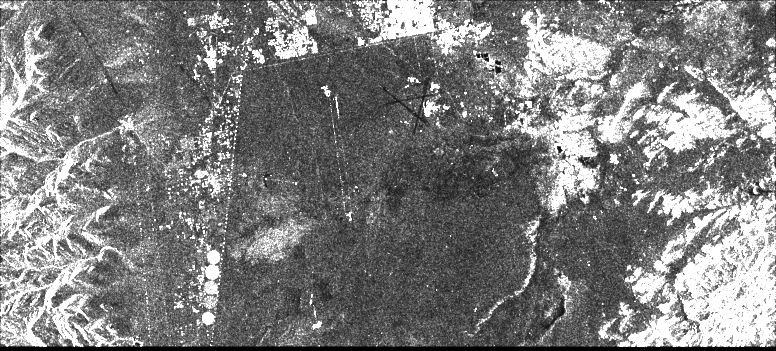

In [51]:
resampled_data = image2_data_interpolator(
    [
        [rows_target2[i],columns_target2[i]] 
        for i =1:length(columns_target2)
    ]
    )


resampled_data = reshape(resampled_data,size(sar_image.data));

SARProcessing.sar2gray(resampled_data[:,1:4:end])

We can plot the images on top of each other, assigning the red color to the secondary image and the blue+green to the primary image:

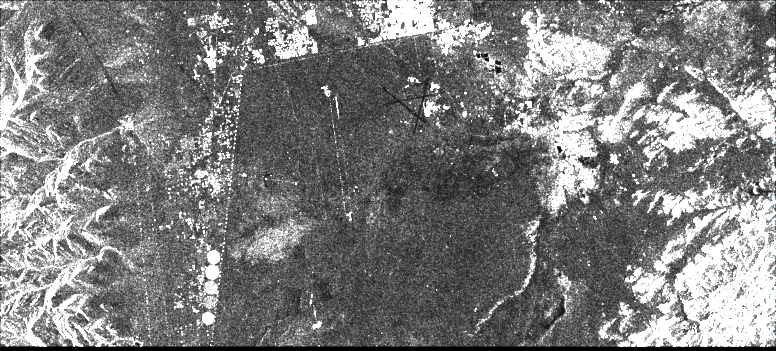

In [52]:
plot_multiple_sar([resampled_data[:,1:4:end],sar_image.data[:,1:4:end],sar_image.data[:,1:4:end]])

In [62]:
dif = abs2.(sar_image.data[:,1:4:end]).- abs2.(resampled_data[:,1:4:end]);

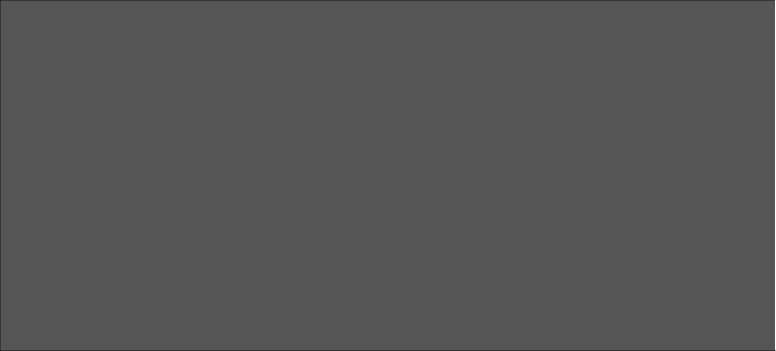

In [63]:

Images.Gray.( (dif .+ 0.1)./0.3)

How do you intepret this image?

## Create Interferogram

### Reramp
Now we add the ramp from the primary image to the deramped secondary resampled image, to be able to use the phase difference.

In [55]:
## reramp the resampled image

mid_burst_state1 = SARProcessing.get_burst_mid_states(sar_image, orbit_interpolator1)
mid_burst_state1 = mid_burst_state1[SARProcessing.get_burst_numbers(sar_image) .==1]
mid_burst_speed1 = SARProcessing.get_speed.(mid_burst_state1)[1]

phase_ramp1 = SARProcessing.phase_ramp(
    collect(rows_range), 
    collect(columns_range), 
1, mid_burst_speed1, sar_image.metadata)


resampled_data .= resampled_data .* exp.(phase_ramp1 .* im);

### Compute the flat interferogram
We now need to compute the phase changes that we would expect just from the different positions of the satellites alone. We do this so we can remove this part of the signal from the interferogram.

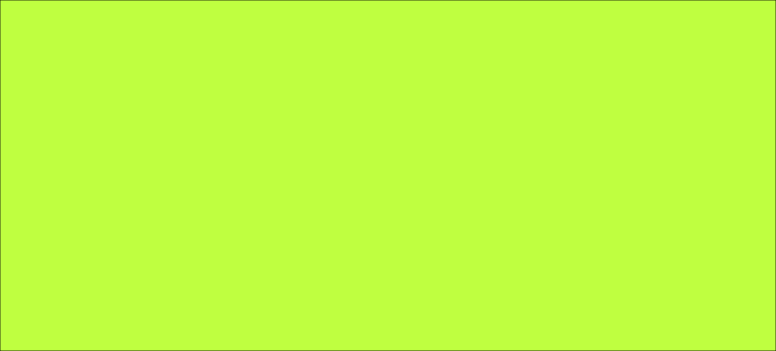

In [56]:
delta_r = (collect(columns_range)' .* ones(length(rows_range))) .- reshape(columns_target2,size(sar_image.data));
delta_r *= SARProcessing.get_range_pixel_spacing(sar_image.metadata);

lambda =  SARProcessing.LIGHT_SPEED/sar_image.metadata.product.radar_frequency

flat_interferogram = exp.(4*pi.*delta_r./lambda.*im);
plot_phase(flat_interferogram[:,1:4:end])

We are now ready to compute the interferogram.

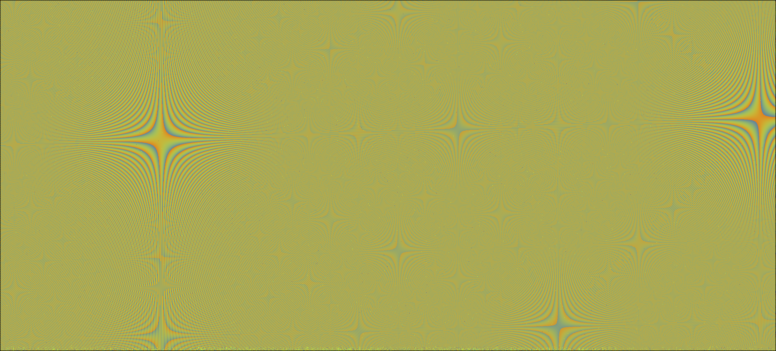

In [61]:
plot_phase((sar_image.data .* conj.(resampled_data) .*flat_interferogram)[:,1:4:end] )

It looks pretty but it is wrong... 
The number of phase fringes acoress this image indicates that there is an error in the azimuth direction of arround 1 pixel in the coregistration (we computed this elsewhere). You can still see the circular fields, which are areas of low phase coherence - this is a good sign. 

We can still compute the InSAR coherence (although underestimated due to the error), which you can see below:

In [58]:
kernel = ones(4,14)
coherence =  complex_coherence(sar_image.data, resampled_data,flat_interferogram, kernel);

#### Coherence

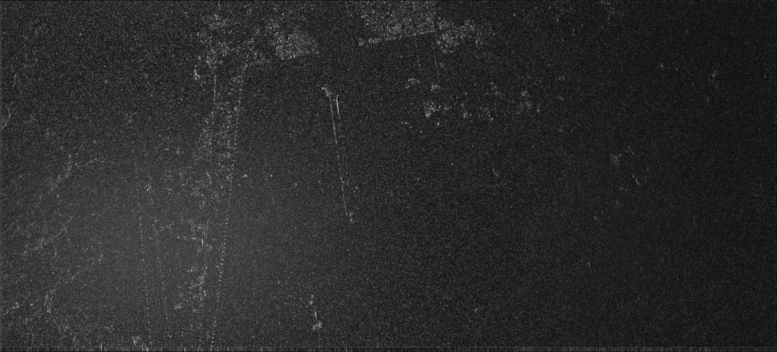

In [59]:
Images.Gray.(abs.(coherence[:,1:4:end]))

#### Coherence phase
The coherence phase is a filtered version of phase shown above. 

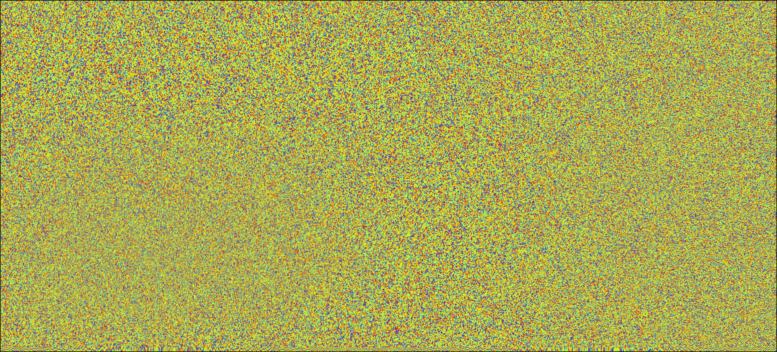

In [60]:
plot_phase(coherence[:,1:4:end])